In [711]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [712]:
loan_data = pd.read_csv('loan.csv')
loan_data.head()

/var/folders/cs/qyzc9w416ddcvcmlpws48d6m0000gn/T/ipykernel_2832/174373214.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data = pd.read_csv('loan.csv')


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


## Data Cleanup

### Data Cleaning steps
<ol>
    <li>
        Drop columns with all null values
    </li>
    <li>
        Drop columns where null value percentage is > 60
    </li>
    <li>Drop columns with all 0 values</li>
    <li>
        Convert term into int
    </li>
    <li>
        Remove % from columns int_rate and revol_util
    </li>
    <li>
        Consider only rows where loan_status != Current as ongoing loans can't be used to determine credit worthiness
    </li>
    <li>
        
    </li>
    
</ol>

In [714]:
# Drop columns with all null values

loan_data.dropna(axis=1, how='all', inplace=True)
loan_data.shape

(39717, 57)

In [715]:
# Drop columns where null value percentage is > 60

null_perc = loan_data.isnull().mean() * 100

columns_to_drop = null_perc[null_perc > 50].index
loan_data.drop(columns=columns_to_drop, inplace=True)

loan_data.shape

(39717, 54)

In [716]:
# Drop columns with all 0 values
zero_cols = loan_data.columns[(loan_data==0).all(axis=0)]
loan_data.drop(columns=zero_cols, inplace=True)
loan_data.shape

(39717, 52)

In [717]:
# Convert term into int

loan_data.term = loan_data.term.apply(lambda x: int(x.replace(' months', '')))
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.0,36,10.65%,162.87,B,B2,...,0.00,Jan-15,171.62,May-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0
1,1077430,1314167,2500,2500,2500.0,60,15.27%,59.83,C,C4,...,1.11,Apr-13,119.66,Sep-13,0.0,1,INDIVIDUAL,0.0,0.0,0.0
2,1077175,1313524,2400,2400,2400.0,36,15.96%,84.33,C,C5,...,0.00,Jun-14,649.91,May-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0
3,1076863,1277178,10000,10000,10000.0,36,13.49%,339.31,C,C1,...,0.00,Jan-15,357.48,Apr-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0
4,1075358,1311748,3000,3000,3000.0,60,12.69%,67.79,B,B5,...,0.00,May-16,67.79,May-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0


In [718]:
# Remove % from columns int_rate and revol_util

loan_data['int_rate'] = loan_data['int_rate'].str.replace('%', '').astype(float)
loan_data['revol_util'] = loan_data['revol_util'].str.replace('%', '').astype(float)
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.0,36,10.65,162.87,B,B2,...,0.00,Jan-15,171.62,May-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0
1,1077430,1314167,2500,2500,2500.0,60,15.27,59.83,C,C4,...,1.11,Apr-13,119.66,Sep-13,0.0,1,INDIVIDUAL,0.0,0.0,0.0
2,1077175,1313524,2400,2400,2400.0,36,15.96,84.33,C,C5,...,0.00,Jun-14,649.91,May-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0
3,1076863,1277178,10000,10000,10000.0,36,13.49,339.31,C,C1,...,0.00,Jan-15,357.48,Apr-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0
4,1075358,1311748,3000,3000,3000.0,60,12.69,67.79,B,B5,...,0.00,May-16,67.79,May-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0


In [719]:
# Consider only rows where loan_status != Current as ongoing loans can't be used to determine credit worthiness

loan_data = loan_data[loan_data['loan_status'] != 'Current']
loan_data['loan_status'].value_counts()

loan_status
Fully Paid     32950
Charged Off     5627
Name: count, dtype: int64

In [720]:
# Clean emp_length column i.e. 
# 1. remove Year(s) suffix
# 2. remove + sign 
# 3. remove nan values 
# 4. convert column type to int

loan_data['emp_length'] = loan_data['emp_length'].str.replace('years', '')
loan_data['emp_length'] = loan_data['emp_length'].str.replace('year', '')
loan_data['emp_length'] = loan_data['emp_length'].str.replace('+', '')
loan_data['emp_length'] = loan_data['emp_length'].apply(lambda x: '0' if x == '< 1 ' else str(x).rstrip())
loan_data = loan_data[loan_data['emp_length'] != 'nan']
loan_data['emp_length'] = loan_data['emp_length'].astype(int)

In [721]:
# Identify non-numeric columns
non_numeric_columns = loan_data.select_dtypes(exclude=[np.number]).columns
print("Non-Numeric Columns:")
print(non_numeric_columns)

# Remove non-numeric columns before correlation
numeric_loan_data = loan_data.select_dtypes(include=[np.number])

Non-Numeric Columns:
Index(['grade', 'sub_grade', 'emp_title', 'home_ownership',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url',
       'desc', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type'],
      dtype='object')


## Data Analysis After Cleanup

Potential High-Income Outliers:
       annual_inc
1463     525000.0
1808     550000.0
5168     725000.0
7247    1782000.0
7511     543000.0
...           ...
36474    700000.0
39089   2039784.0
39098    572400.0
39438    522000.0
39554    616000.0

[65 rows x 1 columns]


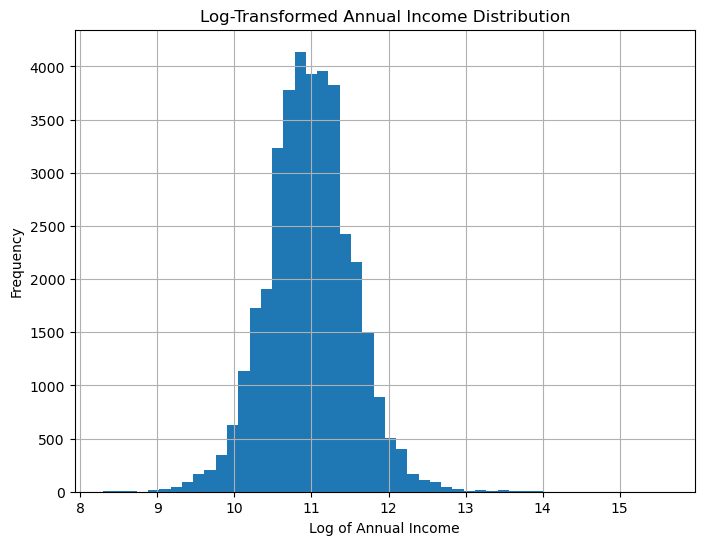

In [723]:
# Identify potential outliers
high_income_outliers = loan_data[loan_data['annual_inc'] > 500000]
print("Potential High-Income Outliers:")
print(high_income_outliers[['annual_inc']])

# Option 1: Cap the outliers
loan_data['annual_inc_capped'] = loan_data['annual_inc'].apply(lambda x: min(x, 500000))

# Option 2: Apply log transformation
loan_data['annual_inc_log'] = np.log1p(loan_data['annual_inc'])

plt.figure(figsize=(8, 6))
loan_data['annual_inc_log'].hist(bins=50)
plt.title('Log-Transformed Annual Income Distribution')
plt.xlabel('Log of Annual Income')
plt.ylabel('Frequency')
plt.show()


Interest Rate Statistics:
count    37544.000000
mean        11.963319
std          3.683012
min          5.420000
25%          8.940000
50%         11.830000
75%         14.420000
max         24.400000
Name: int_rate, dtype: float64


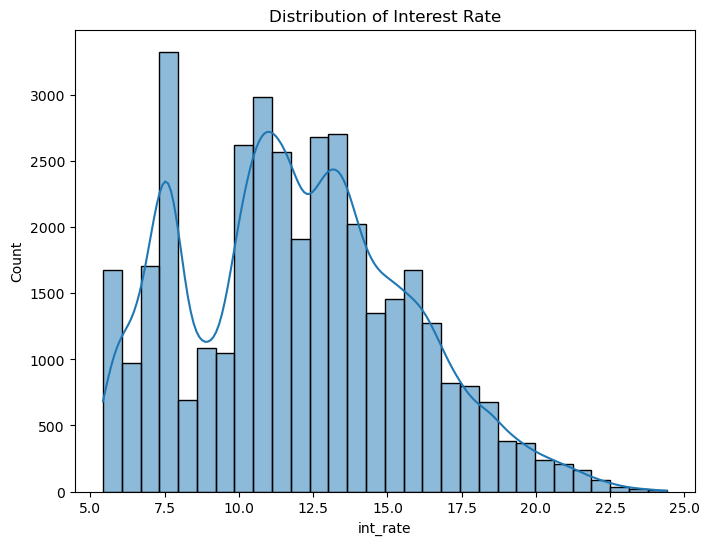

In [724]:
# Interest Rate Distribution (`int_rate`)
int_rate_stats = loan_data['int_rate'].describe()
print("\nInterest Rate Statistics:")
print(int_rate_stats)

plt.figure(figsize=(8, 6))
sns.histplot(loan_data['int_rate'], bins=30, kde=True)
plt.title('Distribution of Interest Rate')
plt.show()


Loan Term Counts:
term
36    28287
60     9257
Name: count, dtype: int64


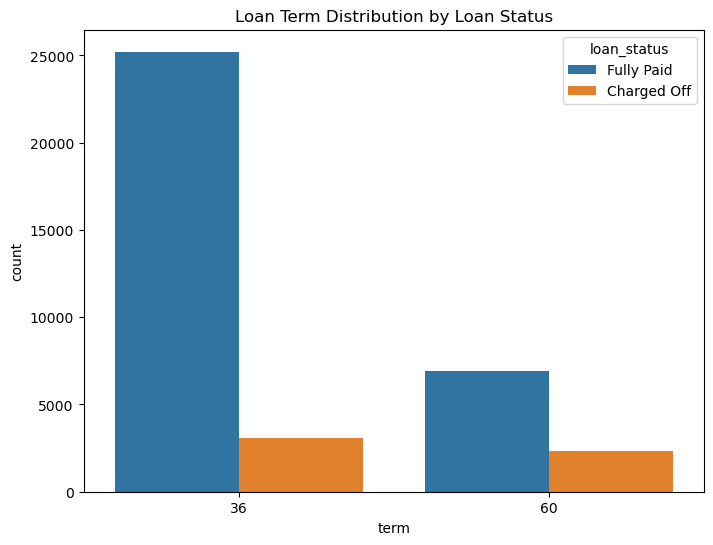

In [725]:
# Loan Term Counts Plot (`term`)
term_counts = loan_data['term'].value_counts()
print("\nLoan Term Counts:")
print(term_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='term', data=loan_data, hue='loan_status')
plt.title('Loan Term Distribution by Loan Status')
plt.show()


Annual Income Statistics:
count    3.754400e+04
mean     6.940708e+04
std      6.467698e+04
min      4.000000e+03
25%      4.100000e+04
50%      6.000000e+04
75%      8.300000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64


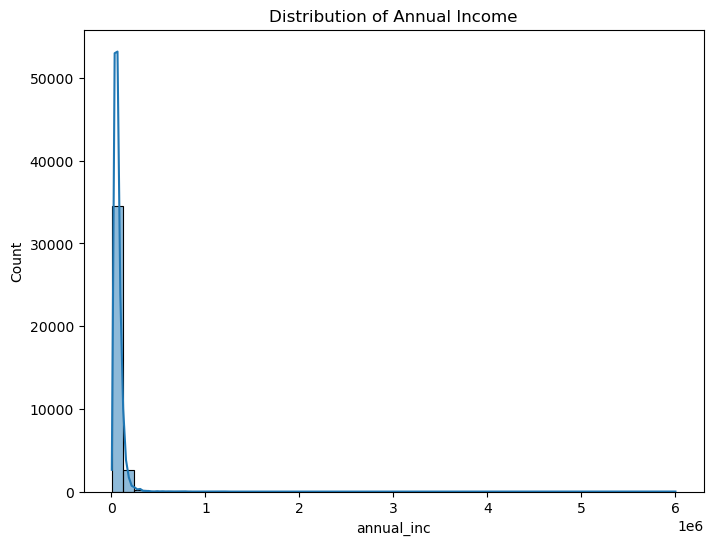

In [726]:
# Distribution of Annual Income (`annual_inc`)
annual_inc_stats = loan_data['annual_inc'].describe()
print("\nAnnual Income Statistics:")
print(annual_inc_stats)

plt.figure(figsize=(8, 6))
sns.histplot(loan_data['annual_inc'], bins=50, kde=True)
plt.title('Distribution of Annual Income')
plt.show()


Debt-to-Income Ratio Statistics:
count    37544.000000
mean        13.284186
std          6.660551
min          0.000000
25%          8.160000
50%         13.380000
75%         18.550000
max         29.990000
Name: dti, dtype: float64


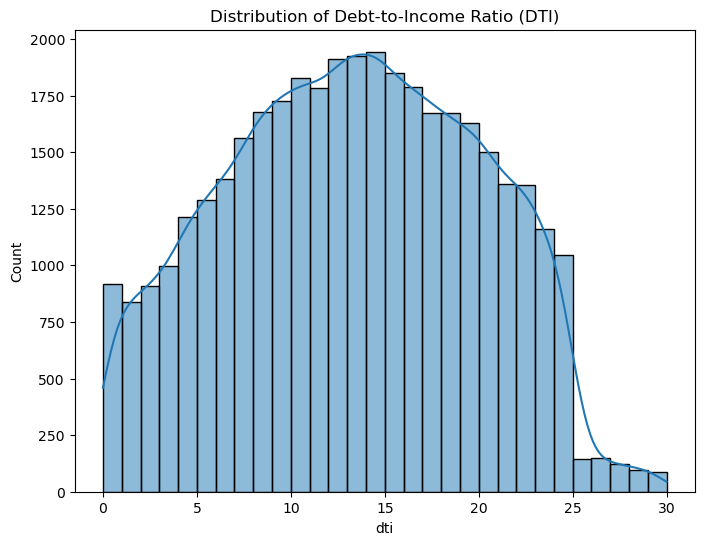

In [727]:
# 7. Distribution of Debt-to-Income Ratio (`dti`)
dti_stats = loan_data['dti'].describe()
print("\nDebt-to-Income Ratio Statistics:")
print(dti_stats)

plt.figure(figsize=(8, 6))
sns.histplot(loan_data['dti'], bins=30, kde=True)
plt.title('Distribution of Debt-to-Income Ratio (DTI)')
plt.show()


Loan Purpose Counts:
purpose
debt_consolidation    17675
credit_card            4899
other                  3713
home_improvement       2785
major_purchase         2080
small_business         1710
car                    1448
wedding                 913
medical                 656
moving                  552
house                   354
vacation                348
educational             317
renewable_energy         94
Name: count, dtype: int64


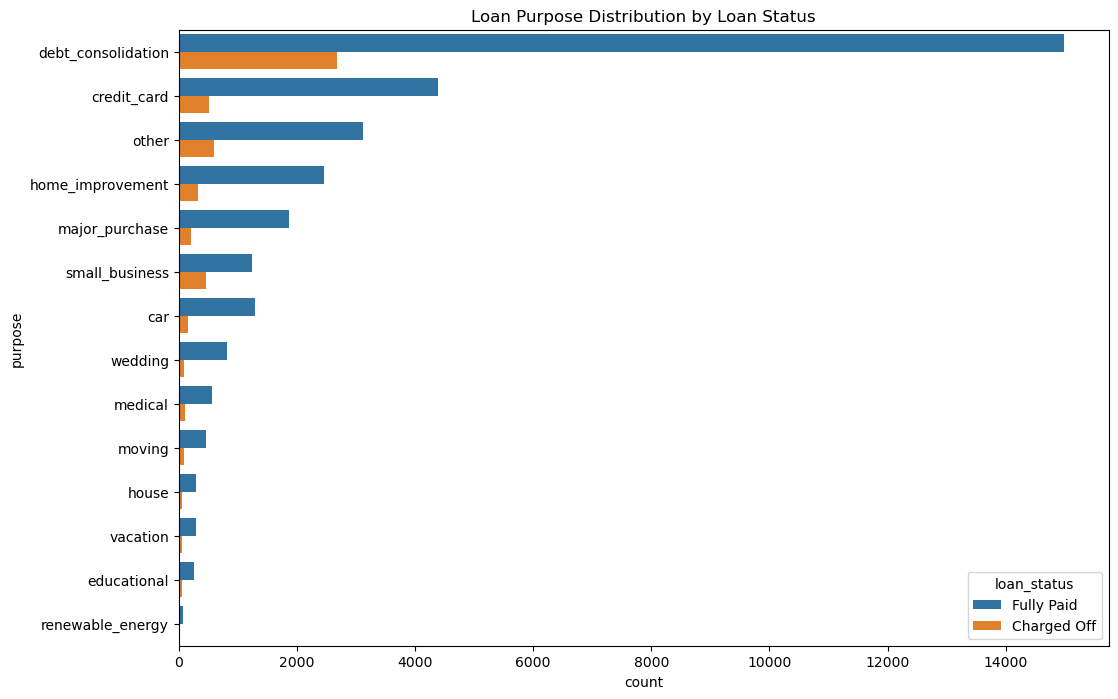

In [728]:
# Purpose of the Loan (`purpose`)
purpose_counts = loan_data['purpose'].value_counts()
print("\nLoan Purpose Counts:")
print(purpose_counts)

plt.figure(figsize=(12, 8))
sns.countplot(y='purpose', data=loan_data, hue='loan_status', order=loan_data['purpose'].value_counts().index)
plt.title('Loan Purpose Distribution by Loan Status')
plt.show()


Number of Open Accounts Statistics:
count    37544.000000
mean         9.298476
std          4.396229
min          2.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         44.000000
Name: open_acc, dtype: float64


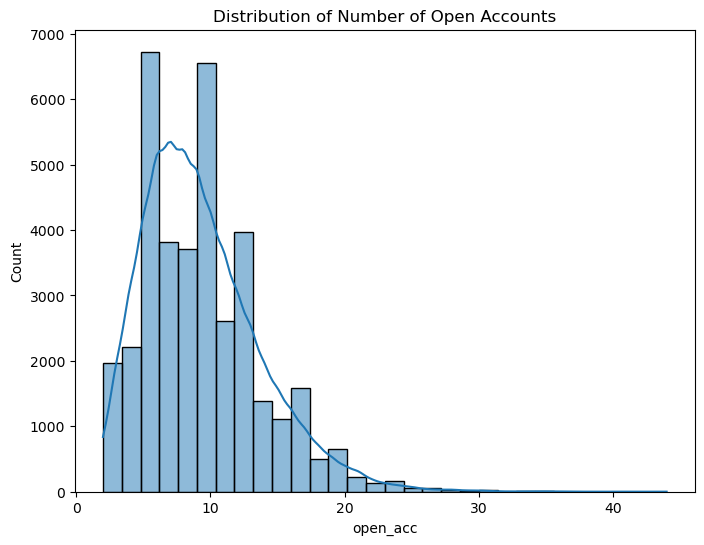

In [729]:
# Number of Open Accounts (`open_acc`)
open_acc_stats = loan_data['open_acc'].describe()
print("\nNumber of Open Accounts Statistics:")
print(open_acc_stats)

plt.figure(figsize=(8, 6))
sns.histplot(loan_data['open_acc'], bins=30, kde=True)
plt.title('Distribution of Number of Open Accounts')
plt.show()


Revolving Credit Utilization Statistics:
count    37497.000000
mean        48.861742
std         28.341493
min          0.000000
25%         25.400000
50%         49.300000
75%         72.400000
max         99.900000
Name: revol_util, dtype: float64


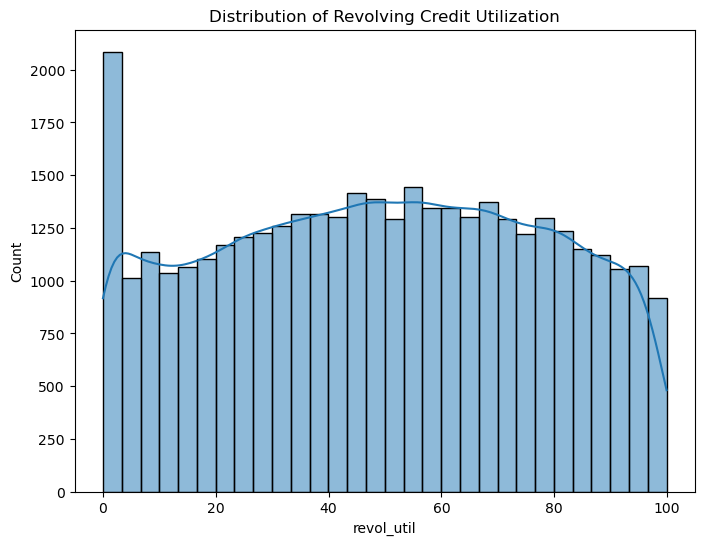

In [730]:
# Revolving Credit Utilization (`revol_util`)
revol_util_stats = loan_data['revol_util'].describe()
print("\nRevolving Credit Utilization Statistics:")
print(revol_util_stats)

plt.figure(figsize=(8, 6))
sns.histplot(loan_data['revol_util'], bins=30, kde=True)
plt.title('Distribution of Revolving Credit Utilization')
plt.show()


Delinquency in Last 2 Years Statistics:
count    37544.000000
mean         0.147107
std          0.493479
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.000000
Name: delinq_2yrs, dtype: float64


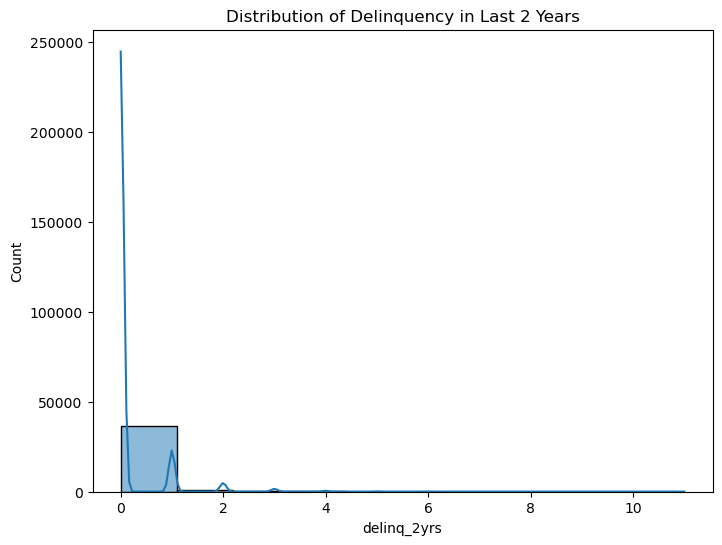

In [731]:
# Delinquency History (`delinq_2yrs`)
delinq_2yrs_stats = loan_data['delinq_2yrs'].describe()
print("\nDelinquency in Last 2 Years Statistics:")
print(delinq_2yrs_stats)

plt.figure(figsize=(8, 6))
sns.histplot(loan_data['delinq_2yrs'], bins=10, kde=True)
plt.title('Distribution of Delinquency in Last 2 Years')
plt.show()


Public Records Statistics:
count    37544.000000
mean         0.053724
std          0.234622
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: pub_rec, dtype: float64


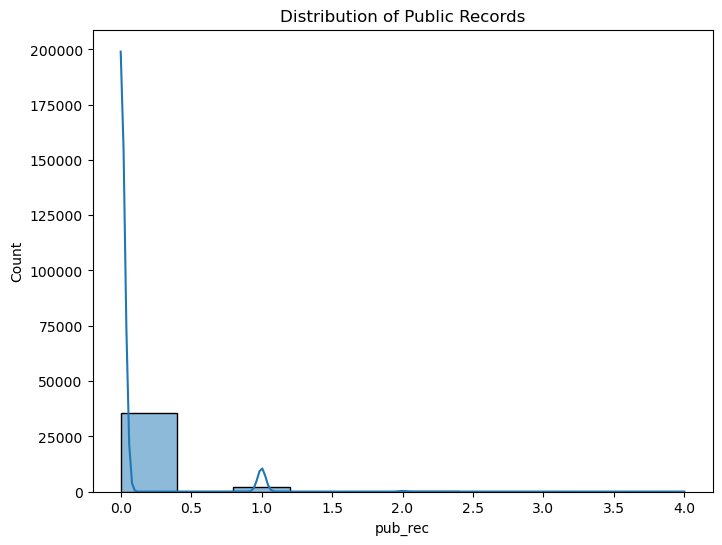

In [732]:
# Public Records (`pub_rec`)
pub_rec_stats = loan_data['pub_rec'].describe()
print("\nPublic Records Statistics:")
print(pub_rec_stats)

plt.figure(figsize=(8, 6))
sns.histplot(loan_data['pub_rec'], bins=10, kde=True)
plt.title('Distribution of Public Records')
plt.show()

## Bivariate Analysis


Log-Transformed Annual Income Statistics:
count    37544.000000
mean        10.981627
std          0.552546
min          8.294300
25%         10.621352
50%         11.002117
75%         11.326608
max         15.607270
Name: annual_inc_log, dtype: float64


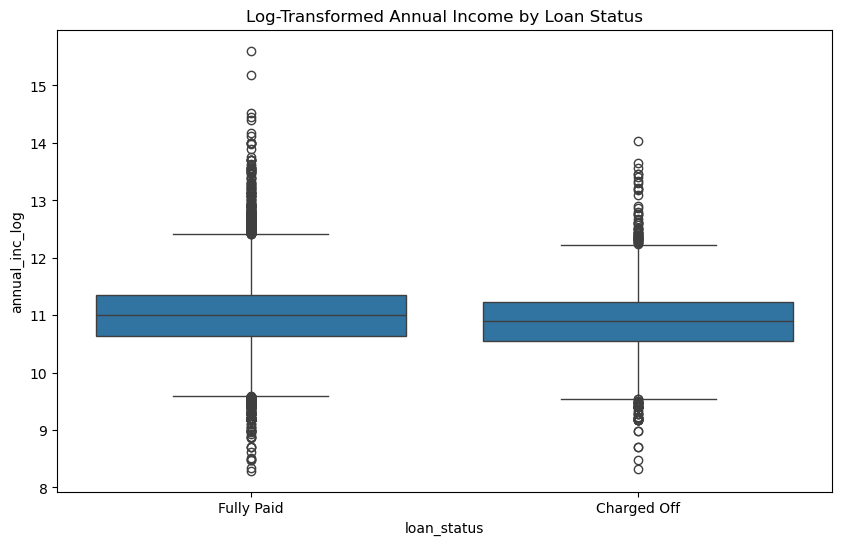

In [734]:
# Annual Income (log-transformed) vs Loan Status
loan_data['annual_inc_log'] = np.log1p(loan_data['annual_inc'])
annual_inc_log_stats = loan_data['annual_inc_log'].describe()
print("\nLog-Transformed Annual Income Statistics:")
print(annual_inc_log_stats)

plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='annual_inc_log', data=loan_data)
plt.title('Log-Transformed Annual Income by Loan Status')
plt.show()

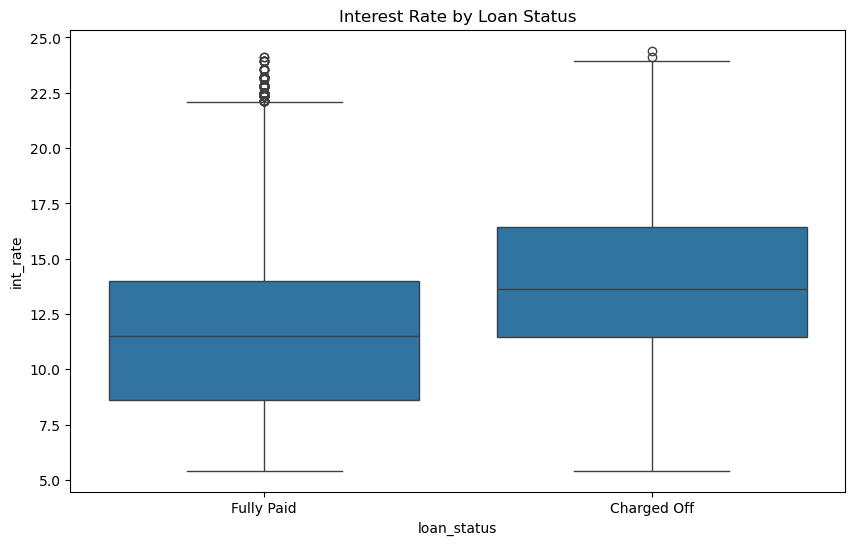

In [735]:
# Interest Rate vs Loan Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='int_rate', data=loan_data)
plt.title('Interest Rate by Loan Status')
plt.show()


Home Ownership Counts:
home_ownership
RENT        18078
MORTGAGE    16595
OWN          2770
OTHER          98
NONE            3
Name: count, dtype: int64


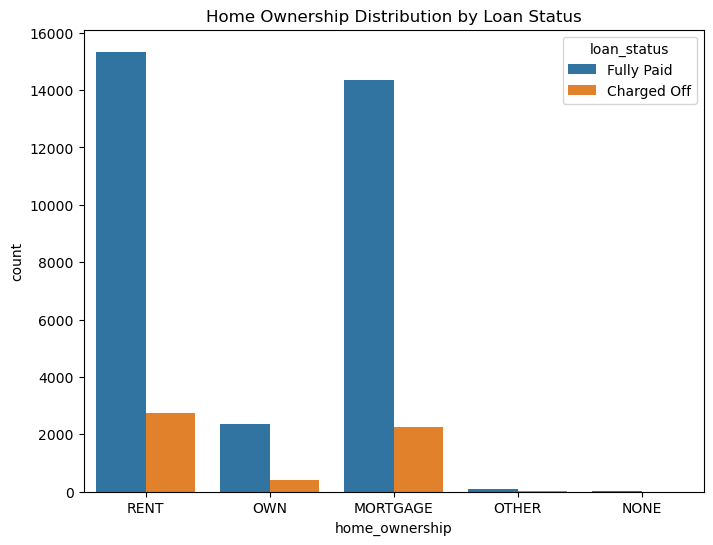

In [736]:
# Home Ownership Distribution by Loan Status (`home_ownership`)
home_ownership_counts = loan_data['home_ownership'].value_counts()
print("\nHome Ownership Counts:")
print(home_ownership_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='home_ownership', data=loan_data, hue='loan_status')
plt.title('Home Ownership Distribution by Loan Status')
plt.show()


Employment Length Counts:
emp_length
10    8488
0     4508
2     4291
3     4012
4     3342
5     3194
1     3169
6     2168
7     1711
8     1435
9     1226
Name: count, dtype: int64


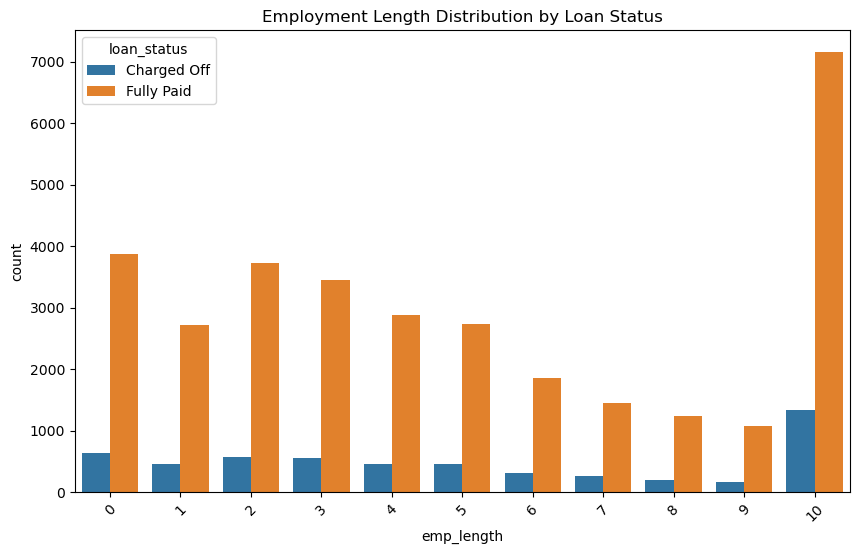

In [737]:
# Employment Length Distribution by Loan Status (`emp_length`)
emp_length_counts = loan_data['emp_length'].value_counts()
print("\nEmployment Length Counts:")
print(emp_length_counts)

plt.figure(figsize=(10, 6))
sns.countplot(x='emp_length', data=loan_data, hue='loan_status')
plt.title('Employment Length Distribution by Loan Status')
plt.xticks(rotation=45)
plt.show()

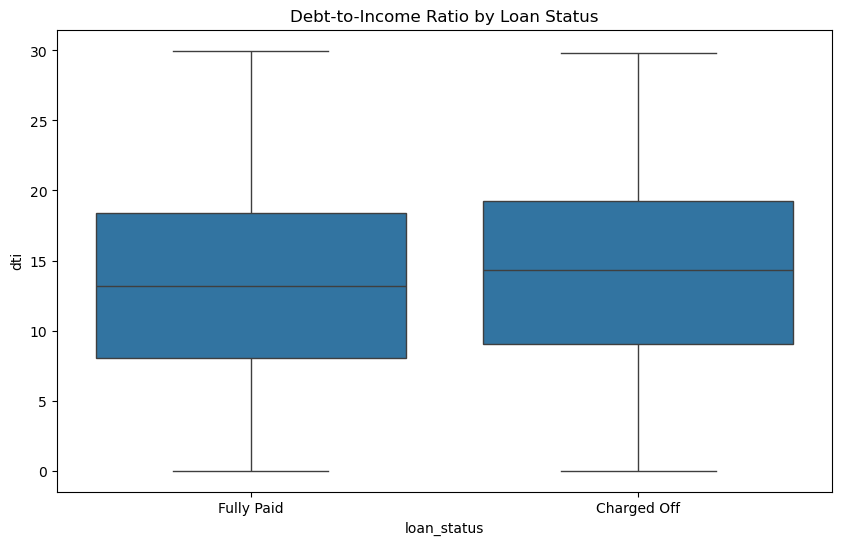

In [738]:
# DTI vs Loan Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='dti', data=loan_data)
plt.title('Debt-to-Income Ratio by Loan Status')
plt.show()

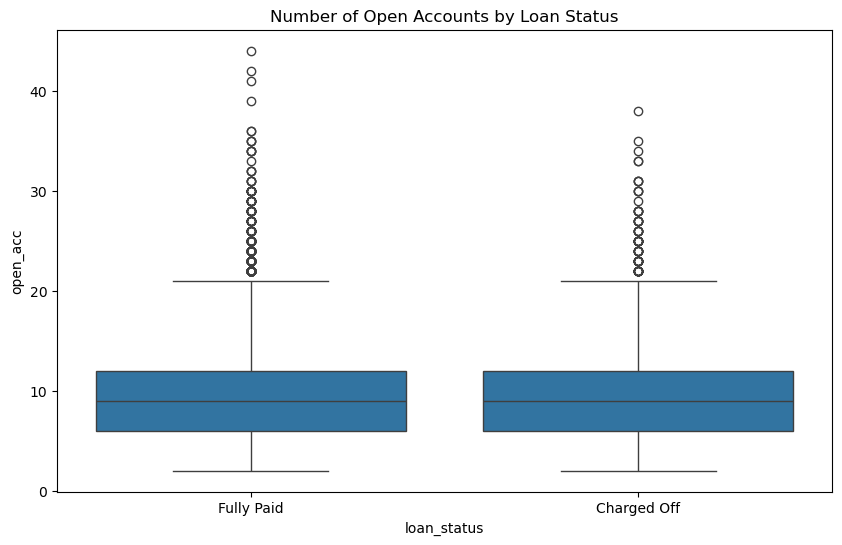

In [739]:
# Open Accounts vs Loan Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='open_acc', data=loan_data)
plt.title('Number of Open Accounts by Loan Status')
plt.show()

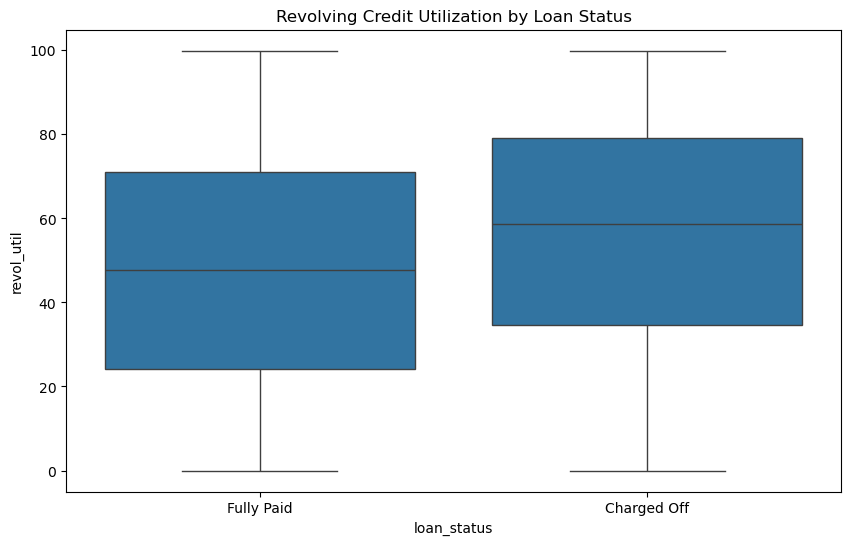

In [740]:
# Revolving Credit Utilization vs Loan Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='revol_util', data=loan_data)
plt.title('Revolving Credit Utilization by Loan Status')
plt.show()

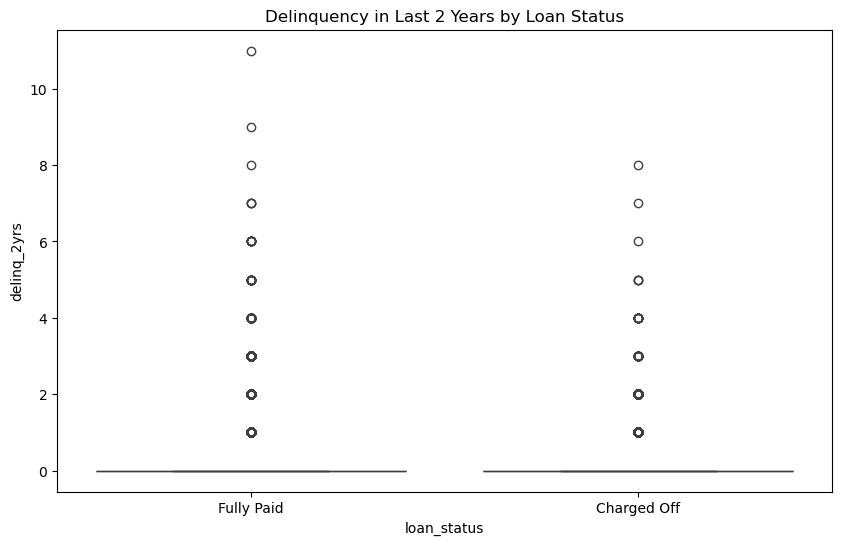

In [741]:
# Delinquency History vs Loan Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='delinq_2yrs', data=loan_data)
plt.title('Delinquency in Last 2 Years by Loan Status')
plt.show()


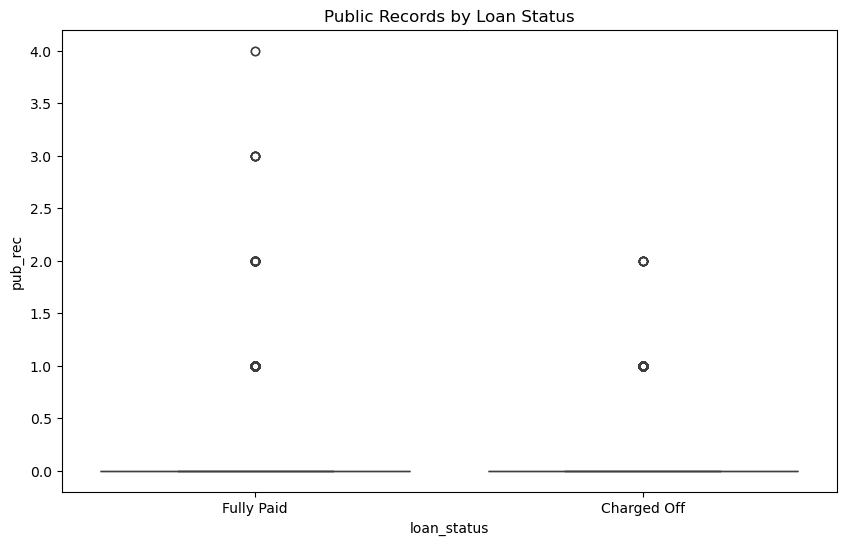

In [742]:
# Public Records vs Loan Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='pub_rec', data=loan_data)
plt.title('Public Records by Loan Status')
plt.show()


Verification Status Counts:
verification_status
Not Verified       16278
Verified           11772
Source Verified     9494
Name: count, dtype: int64


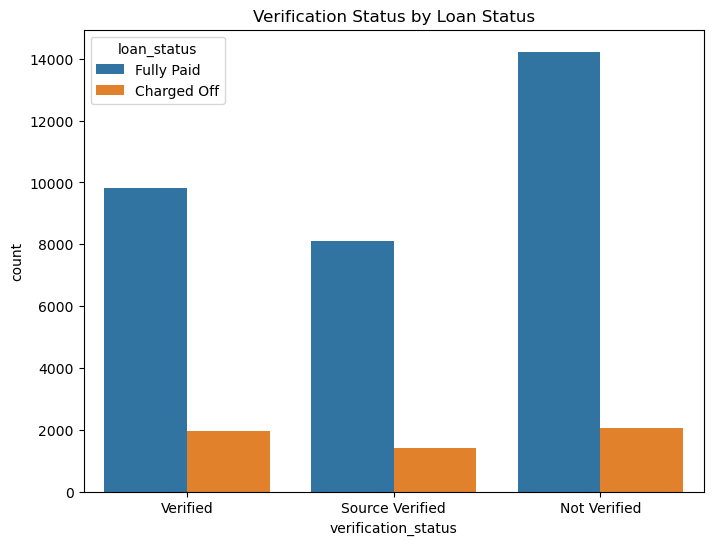

In [743]:
# Verification Status by Loan Status (`verification_status`)
verification_status_counts = loan_data['verification_status'].value_counts()
print("\nVerification Status Counts:")
print(verification_status_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='verification_status', data=loan_data, hue='loan_status')
plt.title('Verification Status by Loan Status')
plt.show()


--- Loan Term vs Loan Status ---
loan_status  Charged Off  Fully Paid
term                                
36              0.108636    0.891364
60              0.251269    0.748731


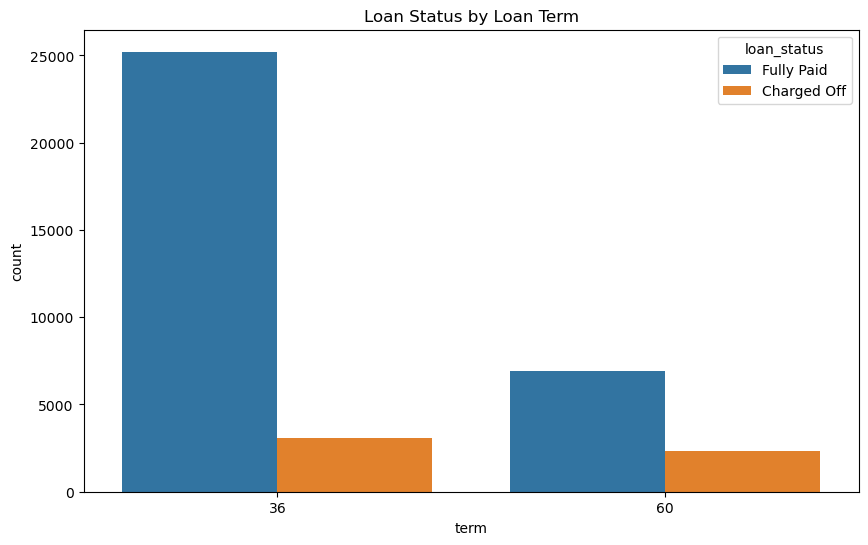

In [744]:
# Analyze default rates by loan term
term_vs_status = pd.crosstab(loan_data['term'], loan_data['loan_status'], normalize='index')
print("\n--- Loan Term vs Loan Status ---")
print(term_vs_status)

plt.figure(figsize=(10, 6))
sns.countplot(x='term', data=loan_data, hue='loan_status')
plt.title('Loan Status by Loan Term')
plt.show()


--- Purpose vs Loan Status ---
loan_status         Charged Off  Fully Paid
purpose                                    
car                    0.107044    0.892956
credit_card            0.104103    0.895897
debt_consolidation     0.151570    0.848430
educational            0.164038    0.835962
home_improvement       0.118492    0.881508
house                  0.166667    0.833333
major_purchase         0.101442    0.898558
medical                0.153963    0.846037
moving                 0.152174    0.847826
other                  0.160517    0.839483
renewable_energy       0.191489    0.808511
small_business         0.270175    0.729825
vacation               0.143678    0.856322
wedding                0.100767    0.899233


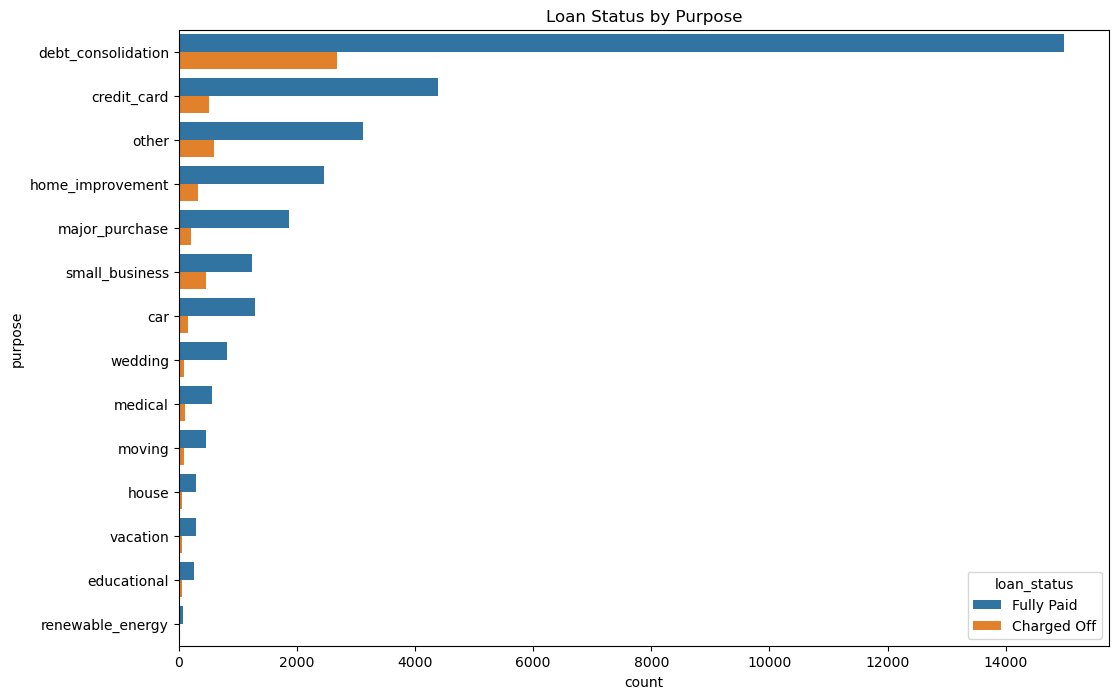

In [745]:
# Analyze default rates by loan purpose
purpose_vs_status = pd.crosstab(loan_data['purpose'], loan_data['loan_status'], normalize='index')
print("\n--- Purpose vs Loan Status ---")
print(purpose_vs_status)

plt.figure(figsize=(12, 8))
sns.countplot(y='purpose', data=loan_data, hue='loan_status', order=loan_data['purpose'].value_counts().index)
plt.title('Loan Status by Purpose')
plt.show()

### Insights from Bivariate Analysis

1. Interest Rate vs Loan Status

	•	Insight: Borrowers who defaulted (Charged Off) had a higher average interest rate (13.82%) compared to those who fully paid their loans (11.61%). This suggests that higher interest rates are associated with a higher risk of default.
	•	Action: Interest rate should be considered a key feature when predicting loan defaults.

2. Term vs Loan Status

	•	Insight: Loans with a 60-month term had a higher default rate (22.6%) compared to loans with a 36-month term (11.1%). Additionally, loans with a 60-month term also had a higher proportion of loans currently being paid (10.7%) compared to 36-month loans (0%).
	•	Action: Loan term is an important variable in understanding loan performance, with longer-term loans being riskier.

3. Employment Length vs Loan Status

	•	Insight: There isn’t a stark difference in default rates based on employment length. However, borrowers with 10+ years of employment had slightly higher default rates (14.99%) compared to other employment lengths.
	•	Action: While employment length should be included in the model, it may not be as strong a predictor as interest rates or loan term.

4. Purpose vs Loan Status

	•	Insight:
	•	The purpose of the loan significantly affects the default rate. Small business loans have the highest default rate (25.9%), while major purchases and weddings have the lowest (10.1%).
	•	Educational, medical, and moving expenses also have relatively high default rates, indicating these purposes are riskier.
	•	Action: Loan purpose is an important categorical variable and should be treated as a key feature in the model, particularly focusing on high-risk purposes like small business loans.

5. Home Ownership vs Loan Status

	•	Insight:
	•	The default rate is slightly higher for renters (15.0%) compared to those with a mortgage (13.2%) or who own their home (14.5%).
	•	This suggests that homeownership provides some stability, although the differences are not as stark as in other segments.
	•	Action: While home ownership status has some predictive value, it may not be as strong a predictor as income segment or loan term.

6. Debt-to-Income Ratio vs Loan Status

	•	Insight: Borrowers who defaulted had a slightly higher average DTI (14.00%) compared to those who fully paid their loans (13.15%). This suggests that higher DTI ratios are associated with higher risk.
	•	Action: DTI should be used as a feature in predicting defaults, though the difference is not very large.

7. Open Accounts vs Loan Status

	•	Insight: The average number of open accounts is similar across loan statuses, but those who defaulted had slightly fewer accounts (9.18) compared to those currently paying (9.94).
	•	Action: The number of open accounts may have some predictive value but likely not as strong as other features like interest rate or term.

8. Revolving Credit Utilization vs Loan Status

	•	Insight: Borrowers who defaulted had higher average revolving credit utilization (55.6%) compared to those who fully paid their loans (47.5%). Higher credit utilization is clearly associated with higher default risk.
	•	Action: Revolving credit utilization is a key feature that should be included in the predictive model.
###

## Correlation Matrix based on 3 variables

/var/folders/cs/qyzc9w416ddcvcmlpws48d6m0000gn/T/ipykernel_2832/2780885191.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data = pd.read_csv('loan.csv')


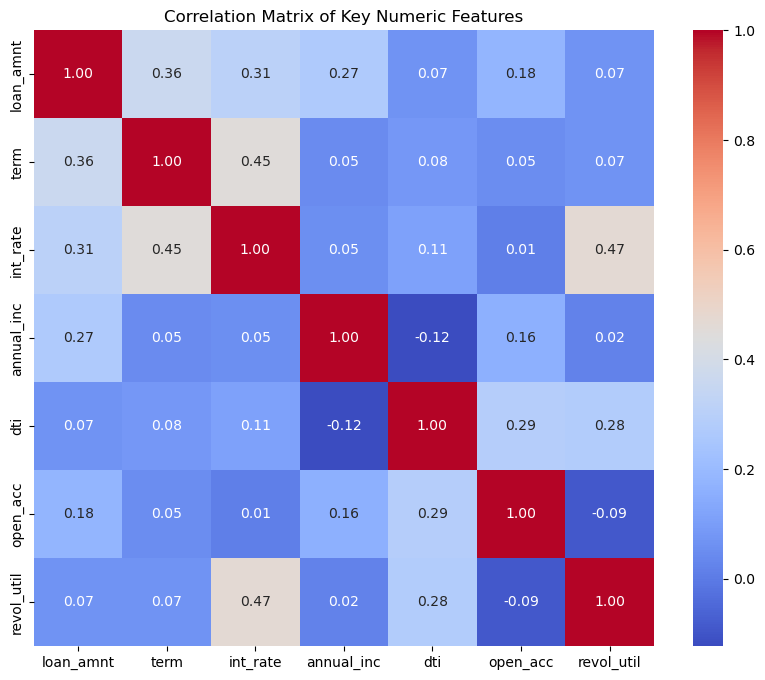

            loan_amnt      term  int_rate  annual_inc       dti  open_acc  \
loan_amnt    1.000000  0.361036  0.309415    0.271149  0.066439  0.177168   
term         0.361036  1.000000  0.451699    0.046675  0.082426  0.050769   
int_rate     0.309415  0.451699  1.000000    0.053185  0.111162  0.010395   
annual_inc   0.271149  0.046675  0.053185    1.000000 -0.122732  0.158200   
dti          0.066439  0.082426  0.111162   -0.122732  1.000000  0.288045   
open_acc     0.177168  0.050769  0.010395    0.158200  0.288045  1.000000   
revol_util   0.066149  0.069834  0.467168    0.017926  0.277951 -0.089891   

            revol_util  
loan_amnt     0.066149  
term          0.069834  
int_rate      0.467168  
annual_inc    0.017926  
dti           0.277951  
open_acc     -0.089891  
revol_util    1.000000  


In [748]:
# Load the dataset
loan_data = pd.read_csv('loan.csv')

# Clean the data: Extract numeric values from the `term` column and convert percentage strings
loan_data['term'] = loan_data['term'].apply(lambda x: int(x.strip().split()[0]))
loan_data['int_rate'] = loan_data['int_rate'].str.replace('%', '').astype(float)
loan_data['revol_util'] = loan_data['revol_util'].str.replace('%', '').astype(float)

# Select relevant numeric features for correlation analysis
numeric_features = ['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'open_acc', 'revol_util']

# Calculate correlation matrix
corr_matrix = loan_data[numeric_features].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Key Numeric Features')
plt.show()

# Print the correlation matrix for reference
print(corr_matrix)

### Insights:
<ol>
    <li>Loan Amount and Term: There’s a moderate positive correlation (0.36) between loan amount and loan term, indicating that larger loans are more likely to have longer terms.</li>
	<li>Interest Rate and Term: A moderate positive correlation (0.45) exists between interest rate and loan term, suggesting that longer-term loans tend to have higher interest rates.</li>
	<li>Interest Rate and Revolving Credit Utilization: A relatively strong positive correlation (0.47) between interest rate and revolving credit utilization indicates that borrowers with higher credit utilization tend to receive higher interest rates.</li>
	<li>Weak Correlations: Most other correlations are weak, indicating that the variables contribute independently to the likelihood of default without much redundancy.</li>
</ol>

### Action:
<ol>
	<li>Given the moderate correlation between interest rate and revolving credit utilization, both features should be included in any analysis, but be aware of potential multicollinearity.</li>
	<li>The weak correlations between most features suggest that they capture different aspects of borrower risk, making them all valuable in a holistic risk assessment.</li>
</ol>

	

## Derived Metrics based Analysis


--- Income Segment vs Loan Status ---
loan_status     Charged Off   Current  Fully Paid
income_segment                                   
Low                0.177039  0.018127    0.804834
Medium             0.145984  0.030522    0.823494
High               0.135886  0.030208    0.833906
Very High          0.107765  0.035955    0.856280


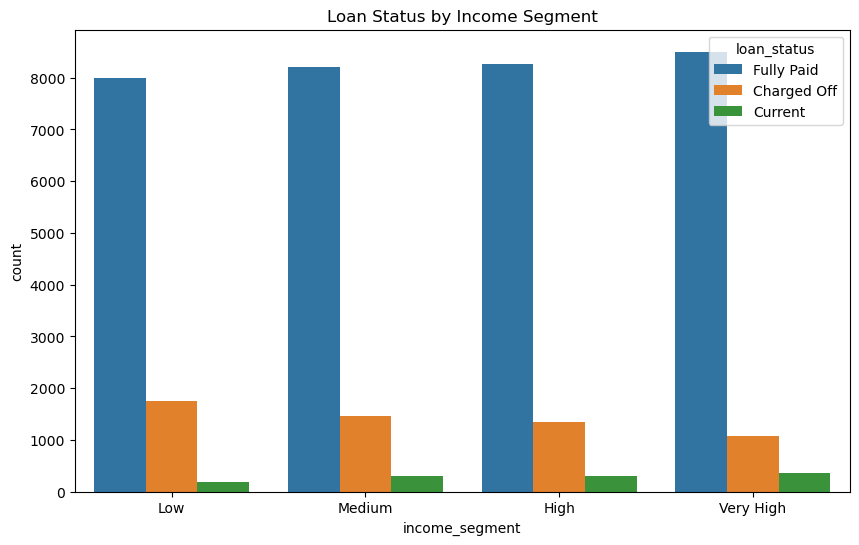

In [751]:
# Segment borrowers into income quartiles
loan_data['income_segment'] = pd.qcut(loan_data['annual_inc'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

# Analyze default rates by income segment
income_segment_vs_status = pd.crosstab(loan_data['income_segment'], loan_data['loan_status'], normalize='index')
print("\n--- Income Segment vs Loan Status ---")
print(income_segment_vs_status)

plt.figure(figsize=(10, 6))
sns.countplot(x='income_segment', data=loan_data, hue='loan_status')
plt.title('Loan Status by Income Segment')
plt.show()